In [1]:
import add_to_syspath
from audiomnist.io.read_dataset import load_alexnet_dataset
from audiomnist.models.autoencoder_spectrogram import build_model as build_model_autoencoder
from audiomnist.models.alexnet import build_model as build_model_alexnet
from audiomnist.train.autoencoder_spectrogram import get_epoch_checkpoint
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tqdm import tqdm 

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.modelzoo import vision_base

In [23]:
K.set_learning_phase(0)
model = keras.models.load_model('../models/decoder_alexnet/model.h5')

In [24]:
with K.get_session().as_default() as sess:
    writer = tf.summary.FileWriter("../logs/graphs/", tf.get_default_graph())

In [25]:

with K.get_session().as_default():
    vision_base.Model.save(
        save_url="../models/decoder_alexnet/frozen_graph_inference.pb",
        input_name='input_2',
        image_shape=[29,29,8],
        output_names=['dense3/Softmax'],
        image_value_range=[0,101]
    )

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


INFO:tensorflow:Froze 30 variables.


INFO:tensorflow:Froze 30 variables.


INFO:tensorflow:Converted 30 variables to const ops.


INFO:tensorflow:Converted 30 variables to const ops.


In [26]:
K.set_learning_phase(0)
K.clear_session()
model = vision_base.Model.load("../models/decoder_alexnet/frozen_graph_inference.pb")

In [27]:
model.show_graph()

In [28]:
def show_feature(layer,n):
    K.clear_session()
    K.set_learning_phase(0)
    model = vision_base.Model.load("../models/decoder_alexnet/frozen_graph_inference.pb")
    with tf.Graph().as_default() as graph, tf.Session() as sess:
        optimizer = tf.train.AdamOptimizer(0.05)
        T = render.make_vis_T_grad(model,
                             objectives.channel(layer,n),                                   
                             param_f=lambda : param.image(29,h=29,channels=8,decorrelate=False,fft=False),
                             relu_gradient_override=True,
                             optimizer = optimizer)

        loss, grads, vis_op, t_image = T("loss"), T("grads"), T("vis_op"), T("input")
        tf.global_variables_initializer().run()
        norm_gradient = tf.norm(grads[0][0])
        
        try:
            losses = []
            grads_list = []
            for i in tqdm(range(512)):
                loss_,_,n_grad = sess.run([loss,vis_op, norm_gradient])
                losses.append(loss_)
                grads_list.append(n_grad)

            vis=t_image.eval()
            print(loss_)
    
        except KeyboardInterrupt:
            log.warning("Interrupted optimization at step {:d}.".format(i+1))
            vis = t_image.eval()
            show(np.hstack(vis))
            
        plt.figure()
        plt.plot(losses)        
        plt.figure()
        plt.plot(grads_list)
    K.clear_session()
    K.set_learning_phase(0)
    decoder = keras.models.load_model('../models/decoder_spectrogram/model.h5')
    result = decoder.predict(vis)
    plt.figure()
    plt.imshow(result[0,:,:,0])

In [31]:
def show_feature_dense(layer,n):
    K.clear_session()
    K.set_learning_phase(0)
    model = vision_base.Model.load("../models/decoder_alexnet/frozen_graph_inference.pb")
    with tf.Graph().as_default() as graph, tf.Session() as sess:
        optimizer = tf.train.AdamOptimizer(0.05)
        T = render.make_vis_T_grad(model,
                             lambda T: T(layer)[0,n],
                             transforms = [],
                             param_f=lambda : param.image(29,h=29,channels=30,fft=False,decorrelate=False),
                             relu_gradient_override=True,
                             optimizer = optimizer)

        loss, grads, vis_op, t_image = T("loss"), T("grads"), T("vis_op"), T("input")
        tf.global_variables_initializer().run()
        norm_gradient = tf.norm(grads[0][0])
        
        try:
            losses = []
            grads_list = []
            for i in tqdm(range(512)):
                loss_,_,n_grad = sess.run([loss,vis_op, norm_gradient])
                losses.append(loss_)
                grads_list.append(n_grad)

            vis=t_image.eval()
            print(loss_)
    
        except KeyboardInterrupt:
            log.warning("Interrupted optimization at step {:d}.".format(i+1))
            vis = t_image.eval()
            show(np.hstack(vis))
            
        plt.figure()
        plt.plot(losses)        
        plt.figure()
        plt.plot(grads_list)
    K.clear_session()
    K.set_learning_phase(0)
    decoder = keras.models.load_model('../models/decoder_spectrogram/model.h5')
    result = decoder.predict(vis)
    plt.figure()
    plt.imshow(result[0,:,:,0])
    return vis,result

100%|██████████| 512/512 [00:25<00:00, 20.03it/s]


428794.97


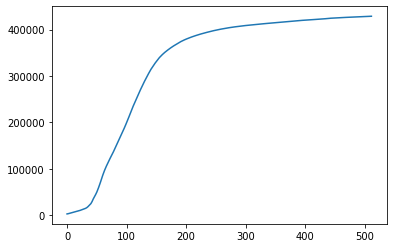

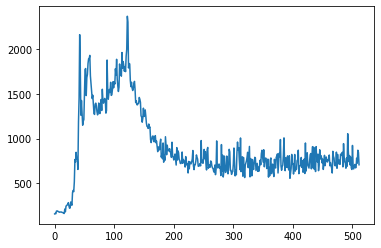

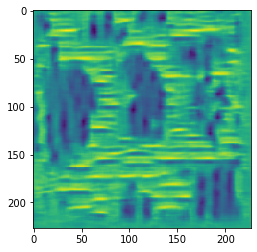

In [32]:
vis, result = show_feature_dense('dense3/BiasAdd',1)

100%|██████████| 512/512 [00:26<00:00, 19.52it/s]


231860.7


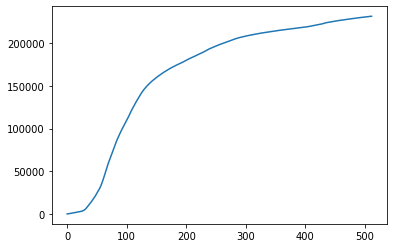

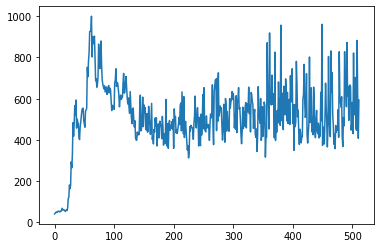

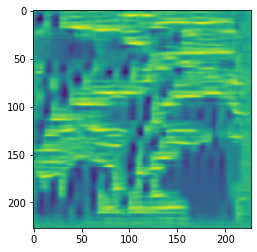

In [34]:
vis, result = show_feature_dense('dense3/BiasAdd',2)

100%|██████████| 512/512 [00:25<00:00, 20.31it/s]


70416.61


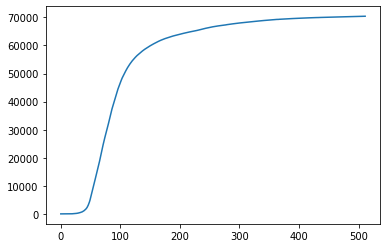

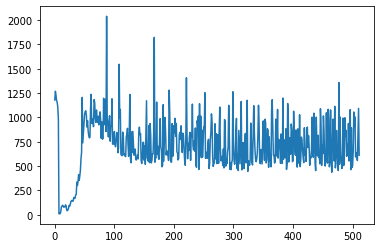

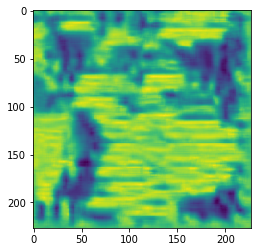

In [10]:
show_feature_dense('dense3/BiasAdd',3)

100%|██████████| 512/512 [00:26<00:00, 19.74it/s]


119060.32


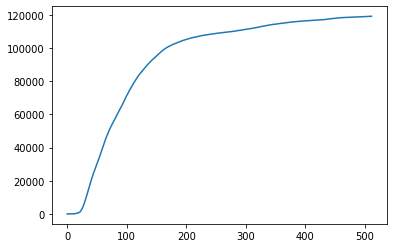

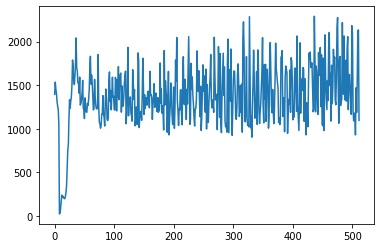

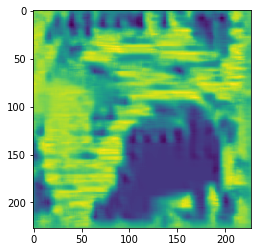

In [11]:
show_feature_dense('dense3/BiasAdd',4)

100%|██████████| 512/512 [00:25<00:00, 19.72it/s]


137702.25


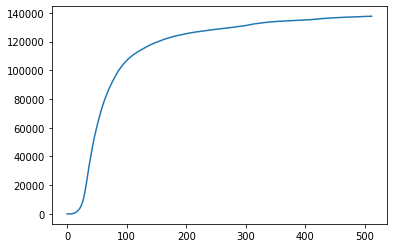

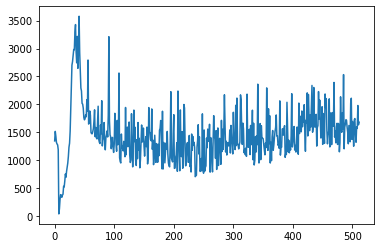

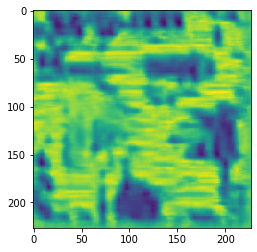

In [12]:
show_feature_dense('dense3/BiasAdd',5)

100%|██████████| 512/512 [00:25<00:00, 19.84it/s]


32101.193


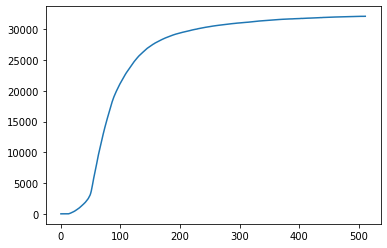

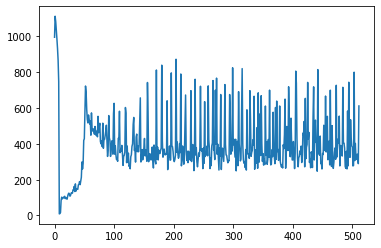

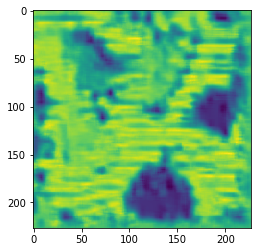

In [13]:
show_feature_dense('dense3/BiasAdd',6)

100%|██████████| 512/512 [00:26<00:00, 19.38it/s]


95692.625


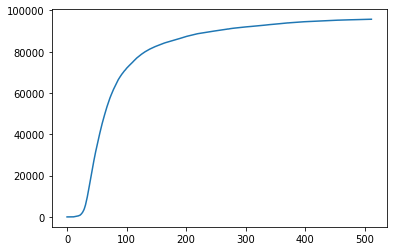

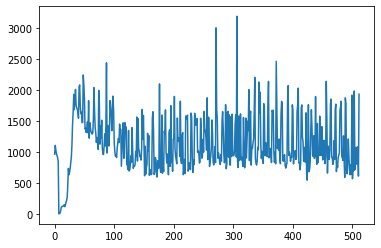

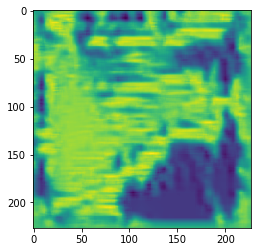

In [14]:
show_feature_dense('dense3/BiasAdd',7)

100%|██████████| 512/512 [00:26<00:00, 19.04it/s]


104518.93


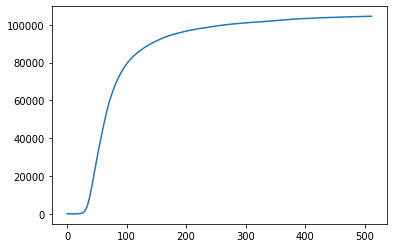

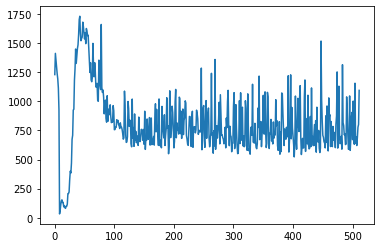

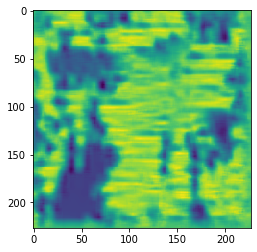

In [15]:
show_feature_dense('dense3/BiasAdd',8)

100%|██████████| 512/512 [00:25<00:00, 19.82it/s]


133839.47


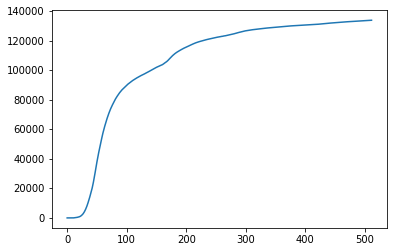

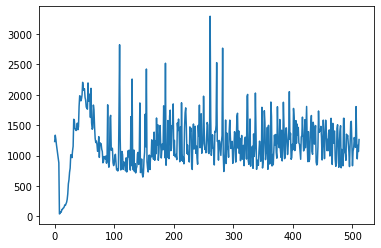

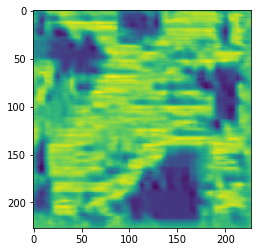

In [16]:
show_feature_dense('dense3/BiasAdd',9)

100%|██████████| 512/512 [00:25<00:00, 19.09it/s]


94852.97


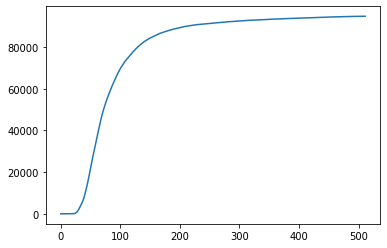

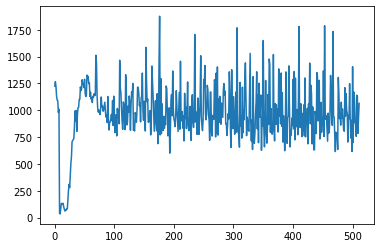

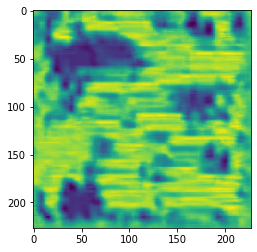

In [18]:
show_feature_dense('dense3/BiasAdd',0)

100%|██████████| 512/512 [00:35<00:00, 14.55it/s]


11.874507


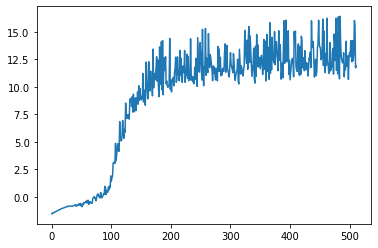

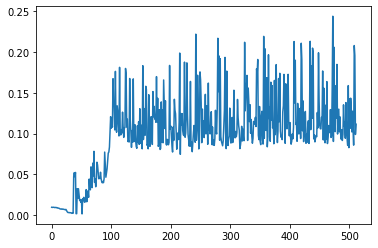

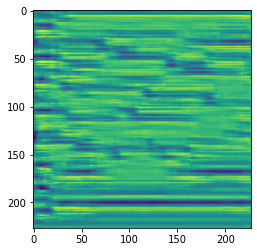

In [19]:
show_feature('leaky_relu1/LeakyRelu',2)

100%|██████████| 512/512 [00:39<00:00, 14.56it/s]


498.6314


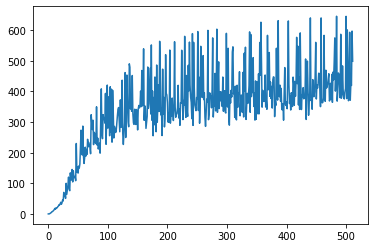

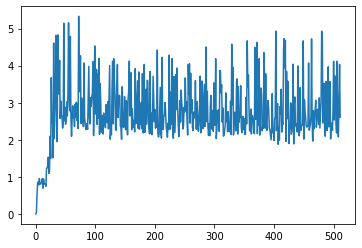

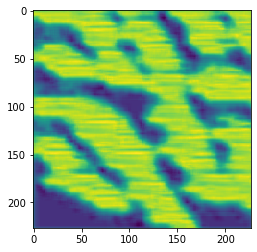

In [34]:
show_feature('leaky_relu2/LeakyRelu',2)

100%|██████████| 512/512 [00:40<00:00, 12.50it/s]


491.69482


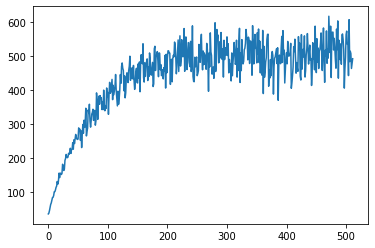

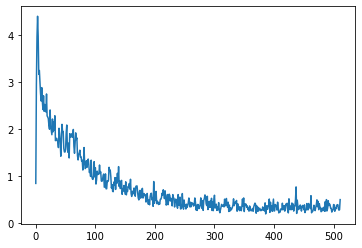

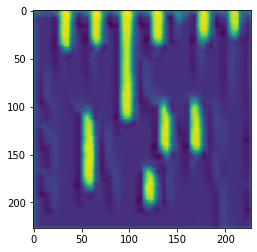

In [37]:
show_feature('leaky_relu3/LeakyRelu',1)

100%|██████████| 512/512 [00:43<00:00, 11.80it/s]


0.0


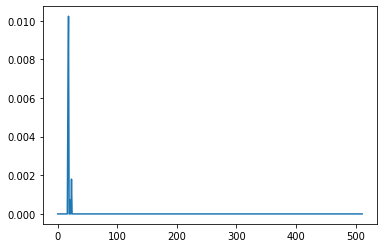

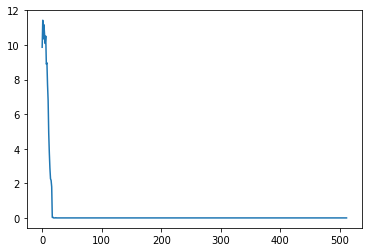

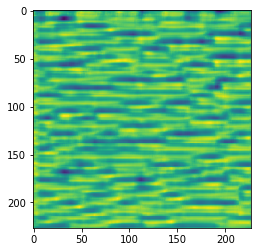

In [39]:
show_feature('conv4/Relu',50)

100%|██████████| 512/512 [00:45<00:00, 12.31it/s]


0.22757208


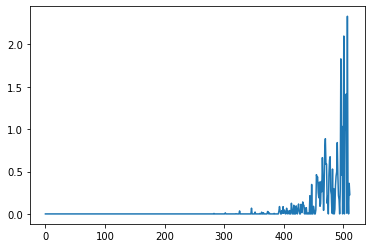

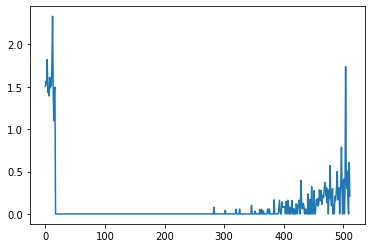

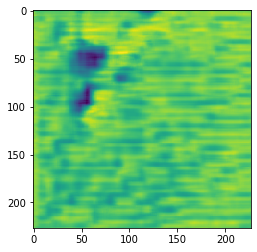

In [40]:
show_feature('conv5/Relu',1)